In [5]:
%matplotlib notebook
from matplotlib.widgets import Button

from IPython.display import display
import ipywidgets as widgets
from ipywidgets import HBox,VBox


import cv2
import numpy as np
import pandas as pd

import os
from plotbee.body import Body
from plotbee.frame import Frame
from plotbee.video import Video
from plotbee.track import Track
from plotbee.utils import read_json
import plotbee.videoplotter as vplt
from collections import defaultdict
import cv2

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 20]




In [23]:
class View():

    def __init__(self,video,video_data):
        
        self.frame_number = 0
        
        self.video_data = Video.load(video_data)
        
        self.video_data.load_video(video)
        
        self.fig, self.ax = plt.subplots(figsize=(10,5))

        plt.title('BeeID Track Labeling Frame: '+str(self.frame_number))
        self.ax.imshow(self.video_data[self.frame_number]._image())
    

    def refresh(self,frame):
        
        self.frame_number = frame
        self.ax.imshow(self.video_data[self.frame_number]._image())
        plt.title('BeeID Track Labeling Frame: '+str(self.frame_number))
        plt.draw()
        

In [24]:
class GUI():
    
    def __init__(self,track,view,frame_number=0):
        
        self.frame_number = frame_number
        
        self.test = 0

        
        self.view = view
        self.track = track
        
        self.current_id = None
        self.annotation = None
        
        self.normal = False
        self.fast = True
        self.frame_changed = False
        
        self.start_over = widgets.Button(description = 'Start Over')   
        self.next_button = widgets.Button(description = 'Next Frame')  
        self.prev_button = widgets.Button(description = 'Prev Frame')  
       
        self.prev_annotation = widgets.Button(description = 'Prev Annot')  
        self.fast_mode = widgets.Button(description='Fast Mode')
        self.normal_mode = widgets.Button(description='Normal Mode')
        
        self.label = widgets.Label("ID Bee")
        self.text = widgets.Text()
        
    def startover_clicked(self,arg):
        self.frame_number= 0
        self.view.refresh(self.frame_number)
        
    def next_frame_clicked(self,arg):
        
        self.frame_number += 1
        self.view.refresh(self.frame_number)    
        
    def prev_frame_clicked(self,arg):
        
        if self.frame_number == 0:
            pass
        else:
            self.frame_number -= 1
            
        self.view.refresh(self.frame_number)
        
    def handle_submit(self,sender):
        self.current_id = self.text.value
        
    def fast_mode_clicked(self,arg):
        self.fast = True
        self.normal = False
        
    def normal_clicked(self,arg):
        self.normal = True
        self.fast = False
        
    def next_frame(self):
        self.frame_number += 1
        self.view.refresh(self.frame_number)    
        
    def on_click(self,event):
        
        
        self.track.add_detection(event.xdata,event.ydata,self.view,self.current_id,self.frame_number)
        
        
        self.next_frame()
                    
    def prev_annotation_clicked(self,arg):
        self.view.show_prev(track=self.track.trajectory[-1],frame=self.frame_number)
        
            
    def start(self):
        
        self.start_over.on_click(self.startover_clicked)
        self.next_button.on_click(self.next_frame_clicked)
        self.prev_button.on_click(self.prev_frame_clicked)
        self.prev_annotation.on_click(self.prev_annotation_clicked)
        self.fast_mode.on_click(self.fast_mode_clicked)
        self.normal_mode.on_click(self.normal_clicked)
        
        self.text.on_submit(self.handle_submit)
    
        left_box = VBox([self.label, self.text])
        right_box = VBox([self.start_over, self.next_button,self.prev_button,self.prev_annotation])
        box_layout = widgets.Layout(display='flex',
                        flex_flow='row',
                        align_items='center',
                        width='50%')
        display(HBox([left_box,right_box],layout=box_layout))
        
        cid = self.view.fig.canvas.mpl_connect('button_press_event', self.on_click)
        
        

    
            

In [25]:
class Track:
    
    def __init__(self):
        
        self.prev_body = None
        self.current_body = None
    
    def add_detection(self,x,y,view,_id,frame_num):
        
        if self.prev_body is not None:            
            self.current_body = Body({3: [(x,y)]}, center=3, connections=[],angle_conn=[3,3],
                             frame=view.video_data[frame_num],body_id=int(_id))
            
            self.prev_body.next = self.current_body

            self.current_body.prev = self.prev_body
            
            
        
        else:
            self.current_body = Body({3: [(x,y)]}, center=3, connections=[],angle_conn=[3,3],
                             frame=view.video_data[frame_num],body_id=int(_id))
            
            
            self.prev_body = self.current_body
        
        view.video_data[frame_num].bodies.append(self.current_body)
        

        


100%|██████████| 6000/6000 [00:01<00:00, 4055.88it/s]


<IPython.core.display.Javascript object>


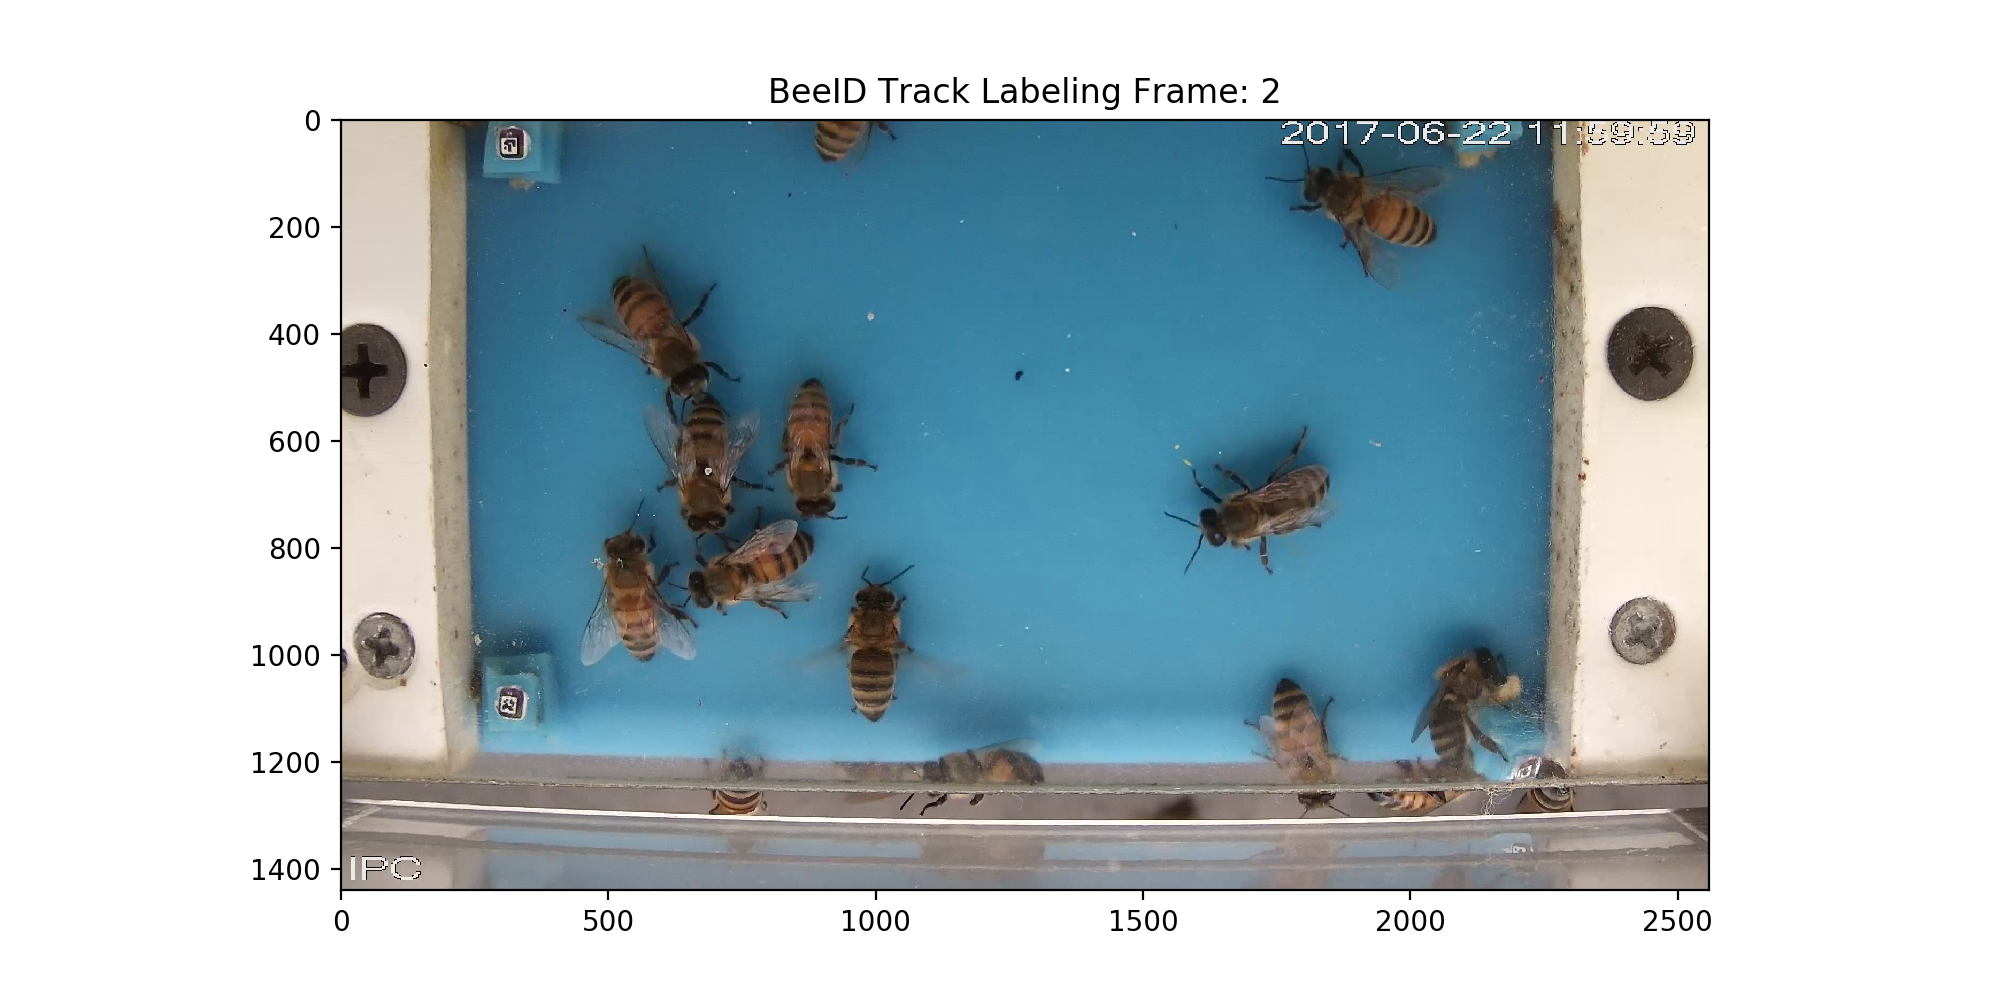

In [26]:
track = Track()
view = View(video="./data/C02_170622120000.mp4",video_data="./data/C02_170622120000_skeleton.json")

gui = GUI(track=track,view=view,frame_number=0)

gui.start()


In [27]:
gui.current_id

'1'

In [28]:
view.video_data[0][-1].next

Body(id=1, parts={3: [(988.4025974025976, 958.0584415584416)])